# Google Drive

In [ ]:
#a = []
#while(1):
 #   a.append('1')

In [ ]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools

#!add-apt-repository -y ppa:alessandro-strada/ppa  # 2>&1 > /dev/null

#!echo "PPA ADDED"
#!apt-get update  # 2>&1 > /dev/null
#!echo "REPO UPDATED"

!apt install software-properties-common dirmngr gnupg-agent
!apt-key adv --keyserver keyserver.ubuntu.com --recv-keys AD5F235DF639B041
!echo 'deb http://ppa.launchpad.net/alessandro-strada/ppa/ubuntu xenial main' | tee /etc/apt/sources.list.d/alessandro-strada-ubuntu-ppa.list >/dev/null
!apt-get update
!apt-get install -y -qq google-drive-ocamlfuse fuse
!echo "install done"

from google.colab import auth

auth.authenticate_user()



from oauth2client.client import GoogleCredentials

creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id {creds.client_id} -secret {creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id {creds.client_id} -secret {creds.client_secret}
#vcode = getpass.getpass()


!mkdir -p drive

!google-drive-ocamlfuse drive



print('Files in Drive:')

!ls drive/

# Imports

In [ ]:
# from google.colab.patches import cv2_imshow
import numpy as np
import cv2
%tensorflow_version 1.14.0
#import tensorflow as tf

import keras

from keras.models import Model
from keras.layers import Dense,LSTM,Input,concatenate,Dropout
from keras.utils.vis_utils import plot_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

#Train

# Feature extraction

## Parameters

In [ ]:
n_frames=18

#n_samples=10
# Parameters for feature extraction
feature_params = dict( maxCorners = 1,
                         qualityLevel = 0.0001,
                         minDistance = 5,
                         blockSize = 5 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (66,100),
                  maxLevel = 30,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.001))


## ***Womanwalk***


In [ ]:

import os
X1 = []
y1 = []
lbl=1
n_samples=371
dir_i = 'drive/movements2/'

for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  file_name=dir_i+'womanwalk ('+ (str(i+1))+')/S (1).'+frmt
  print('current image is:',file_name)
  img1 = cv2.imread(file_name)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X1.append(p0[k])

  for j in range(1,n_frames):
    file_name2 = dir_i+'womanwalk ('+str(i+1)+')/S ('+str(j+1)+').'+frmt
    img2 = cv2.imread(file_name2)
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X1.append(p1)
X1 = np.array([X1[ii][0][0] for ii in range(len(X1))])


xx1 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx1[iii,ii,j,:] = X1[ iii+(9*j + ii)]
      np.save("xx1", xx1)


## ***Walkingforwardchild***



In [ ]:
X2=[]
y2=[]
dir_i = 'drive/movements2/walkingforwardchild/'
lbl=2
n_samples=371
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  file_name = dir_i+'walkingforwardchild ('+ (str(i+1))+')/S (1).'+frmt
  img1 = cv2.imread(file_name)
  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X2.append(p0[k])

  for j in range(1,n_frames):
    file_name2 = dir_i+'walkingforwardchild ('+ (str(i+1))+')/S ('+str(j+1)+').'+frmt
    img2 = cv2.imread(file_name2)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X2.append(p1)

xx2 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx2[iii,ii,j,:] = X2[ iii+(9*j + ii)]
      np.save("xx2", xx2)

## ***Walkingforwardadult***


In [ ]:
#i pip install tensorflow

#ssss
#ssssfhhfndnsifdfj
#ssssss


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
X3=[]
y3=[]
dir_i = 'drive/movements2/walkingforwardadult/'
lbl=3
n_samples=371
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'walkingforwardadult ('+(str(i+1))+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X3.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'walkingforwardadult ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X3.append(p1)

xx3 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx3[iii,ii,j,:] = X3[ iii+(9*j + ii)]
      np.save("xx3", xx3)



## ***Walkingbackwardadult***

In [ ]:
X4=[]
y4=[]
dir_i = 'drive/movements2/walkingbackwardadult/'
lbl=4
n_samples=371
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'walkingbackwardadult ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X4.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'walkingbackwardadult ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X4.append(p1)

xx4 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx4[iii,ii,j,:] = X4[ iii+(9*j + ii)]
      np.save("xx4", xx4)

## ***Walkingbackwadchild***

In [ ]:
X5=[]
y5=[]
dir_i = 'drive/movements2/walkingbackwadchild/'
lbl=5
n_samples=371
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'walkingbackwardchild ('+str(i+1)+')/S (1).'+frmt)
  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X5.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'walkingbackwardchild ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X5.append(p1)

xx5 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx5[iii,ii,j,:] = X5[ iii+(9*j + ii)]
      np.save("xx5", xx5)

## ***Swing***

In [ ]:
X6=[]
y6=[]
dir_i = 'drive/movements2/swing/'
lbl=6
n_samples=372
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'swing ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X6.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'swing ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X6.append(p1)

xx6 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx6[iii,ii,j,:] = X6[ iii+(9*j + ii)]
      np.save("xx6", xx6)

## ***Sexy***

In [ ]:
X7=[]
y7=[]
dir_i = 'drive/movements2/sexy/'
lbl=7
n_samples=370
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'sexy ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X7.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'sexy ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X7.append(p1)

xx7 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx7[iii,ii,j,:] = X7[ iii+(9*j + ii)]
      np.save("xx7", xx7)

## ***Runningforwardchild***

In [ ]:
X8=[]
y8=[]
dir_i = 'drive/movements2/runningforwardchild/'
lbl=8
n_samples=353
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'runningforwardchild ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X8.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'runningforwardchild ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X8.append(p1)

xx8 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx8[iii,ii,j,:] = X8[ iii+(9*j + ii)]
      np.save("xx8", xx8)

## ***Runningforwardadult***

In [ ]:
X9=[]
y9=[]
dir_i = 'drive/movements2/runningforwardadult/'
lbl=9
n_samples=352
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'runningforwardadult ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X9.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'runningforwardadult ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X9.append(p1)

xx9 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx9[iii,ii,j,:] = X9[ iii+(9*j + ii)]
      np.save("xx9", xx9)

## ***Runningbackwardchild***

In [ ]:
X10=[]
y10=[]
dir_i = 'drive/movements2/runningbackwardchild/'
lbl=10
n_samples=353
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'runningbackwardchild ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X10.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'runningbackwardchild ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X10.append(p1)

xx10 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx10[iii,ii,j,:] = X10[ iii+(9*j + ii)]
      np.save("xx10", xx10)

## ***Runningbackwardadult***

In [ ]:
X11=[]
y11=[]
dir_i = 'drive/movements2/runningbackwardadult/'
lbl=11
n_samples=352
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'runningbackwardadult ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X11.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'runningbackwardadult ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X11.append(p1)

xx11 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx11[iii,ii,j,:] = X11[ iii+(9*j + ii)]
      np.save("xx11", xx11)

## ***Riflerun***

In [ ]:
X12=[]
y12=[]
dir_i = 'drive/movements2/riflerun/'
lbl=12
n_samples=352
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'riflerun ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X12.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'riflerun ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X12.append(p1)

xx12 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx12[iii,ii,j,:] = X12[ iii+(9*j + ii)]
      np.save("xx12", xx12)

## ***Jump***

In [ ]:
X13=[]
y13=[]
dir_i = 'drive/movements2/jump/'
lbl=13
n_samples=353
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'jump ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X13.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'jump ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X13.append(p1)

xx13 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx13[iii,ii,j,:] = X13[ iii+(9*j + ii)]
      np.save("xx13", xx13)

## ***Drunk***

In [ ]:
X14=[]
y14=[]
dir_i = 'drive/movements2/drunk/'
lbl=14
n_samples=372
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'drunk ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X14.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'drunk ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X14.append(p1)

xx14 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx14[iii,ii,j,:] = X14[ iii+(9*j + ii)]
      np.save("xx14", xx14)

## ***Cowboy***

In [ ]:
X15=[]
y15=[]
dir_i = 'drive/movements2/cowboy/'
lbl=15
n_samples=316
for i in range(n_samples):
  frmt='png'
  print('i = {}'.format(i))
  img1 = cv2.imread(dir_i+'cowboy ('+str(i+1)+')/S (1).'+frmt)

  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    X15.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(dir_i+'cowboy ('+str(i+1)+')/S ('+str(j+1)+').'+frmt)
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      X15.append(p1)

xx15 = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xx15[iii,ii,j,:] = X15[ iii+(9*j + ii)]
      np.save("xx15", xx15)

# ***Features & Targets***

In [ ]:
xx1=np.load("xx1.npy")
xx2=np.load("xx2.npy")
xx3=np.load("xx3.npy")
xx4=np.load("xx4.npy")
xx5=np.load("xx5.npy")
xx6=np.load("xx6.npy")
xx7=np.load("xx7.npy")
xx8=np.load("xx8.npy")
xx9=np.load("xx9.npy")
xx10=np.load("xx10.npy")
xx11=np.load("xx11.npy")
xx12=np.load("xx12.npy")
xx13=np.load("xx13.npy")
xx14=np.load("xx14.npy")
xx15=np.load("xx15.npy")
allx = np.concatenate([xx1,xx2,xx3,xx4,xx5,xx6,xx7,xx8,xx9,xx10,xx11,xx12,xx13,xx14,xx15],axis=0)
np.save('allx.npy', allx)
allx.shape

(5400, 9, 18, 2)

In [ ]:
ally = np.hstack([np.zeros(xx1.shape[0]), np.ones(xx2.shape[0]), 2 * np.ones(xx3.shape[0]), 3 * np.ones(xx4.shape[0]),4 * np.ones(xx5.shape[0]),5 * np.ones(xx6.shape[0]),6 * np.ones(xx7.shape[0]),7 * np.ones(xx8.shape[0]),8 * np.ones(xx9.shape[0]),9 * np.ones(xx10.shape[0]),10 * np.ones(xx11.shape[0]),11 * np.ones(xx12.shape[0]),12 * np.ones(xx13.shape[0]),13 * np.ones(xx14.shape[0]),14 * np.ones(xx15.shape[0])])
np.save('ally.npy', ally)

ally.shape

(5400,)

# ***Normalization***

In [ ]:
# normalize data by min max method.
from sklearn.preprocessing import MinMaxScaler
allx = allx.reshape((5400* 9 * 18, 2))
scaler  = MinMaxScaler(copy=True, feature_range=(0, 1))
allx = np.reshape(scaler.fit_transform(allx), (5400, 9, 18, 2))


In [ ]:
p=.7
units=200
inp1 = Input(shape=(n_frames,2,))
inp2 = Input(shape=(n_frames,2,))
inp3 = Input(shape=(n_frames,2,))
inp4 = Input(shape=(n_frames,2,))
inp5 = Input(shape=(n_frames,2,))
inp6 = Input(shape=(n_frames,2,))
inp7 = Input(shape=(n_frames,2,))
inp8 = Input(shape=(n_frames,2,))
inp9 = Input(shape=(n_frames,2,))

x1 = LSTM(units, return_sequences=False)(inp1)
d1 = Dropout(.2)(x1)
x2 = LSTM(units, return_sequences=False)(inp2)
d2 = Dropout(.2)(x2)
x3 = LSTM(units, return_sequences=False)(inp3)
d3 = Dropout(.2)(x3)
x4 = LSTM(units, return_sequences=False)(inp4)
d4 = Dropout(.2)(x4)
x5 = LSTM(units, return_sequences=False)(inp5)
d5 = Dropout(.2)(x5)
x6 = LSTM(units, return_sequences=False)(inp6)
d6 = Dropout(.2)(x6)
x7 = LSTM(units, return_sequences=False)(inp7)
d7 = Dropout(.2)(x7)
x8 = LSTM(units, return_sequences=False)(inp8)
d8 = Dropout(.2)(x8)
x9 = LSTM(units, return_sequences=False)(inp9)
d9 = Dropout(.2)(x9)
x10= LSTM(units, return_sequences=False)(inp10)
d10 = Dropout(.2)(x10)


x = concatenate([x1,d1,x2,d2,x3,d3,x4,d4,x5,d5,x6,d6,x7,d7,x8,d8,x9,d9])
# x = Dropout(p)(x)
xd1 = Dense(1000)(x)
d1 = Dropout(.2)(xd1)
xd2 = Dense(1000)(d1)
d2 = Dropout(.2)(xd2)
xd3 = Dense(1000)(d2)
d3 = Dropout(.2)(xd3)
xd4 = Dense(1000)(d3)
d4 = Dropout(.2)(xd4)


x = Dense(15,activation='softmax')(d4)

model = Model([inp1,inp2,inp3,inp4,inp5,inp6,inp7,inp8,inp9],x)

opti = keras.optimizers.Nadam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opti,metrics = ['acc'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 18, 2)        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 18, 2)        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 18, 2)        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 18, 2)        0                                            
____________________________________________________________________________________________

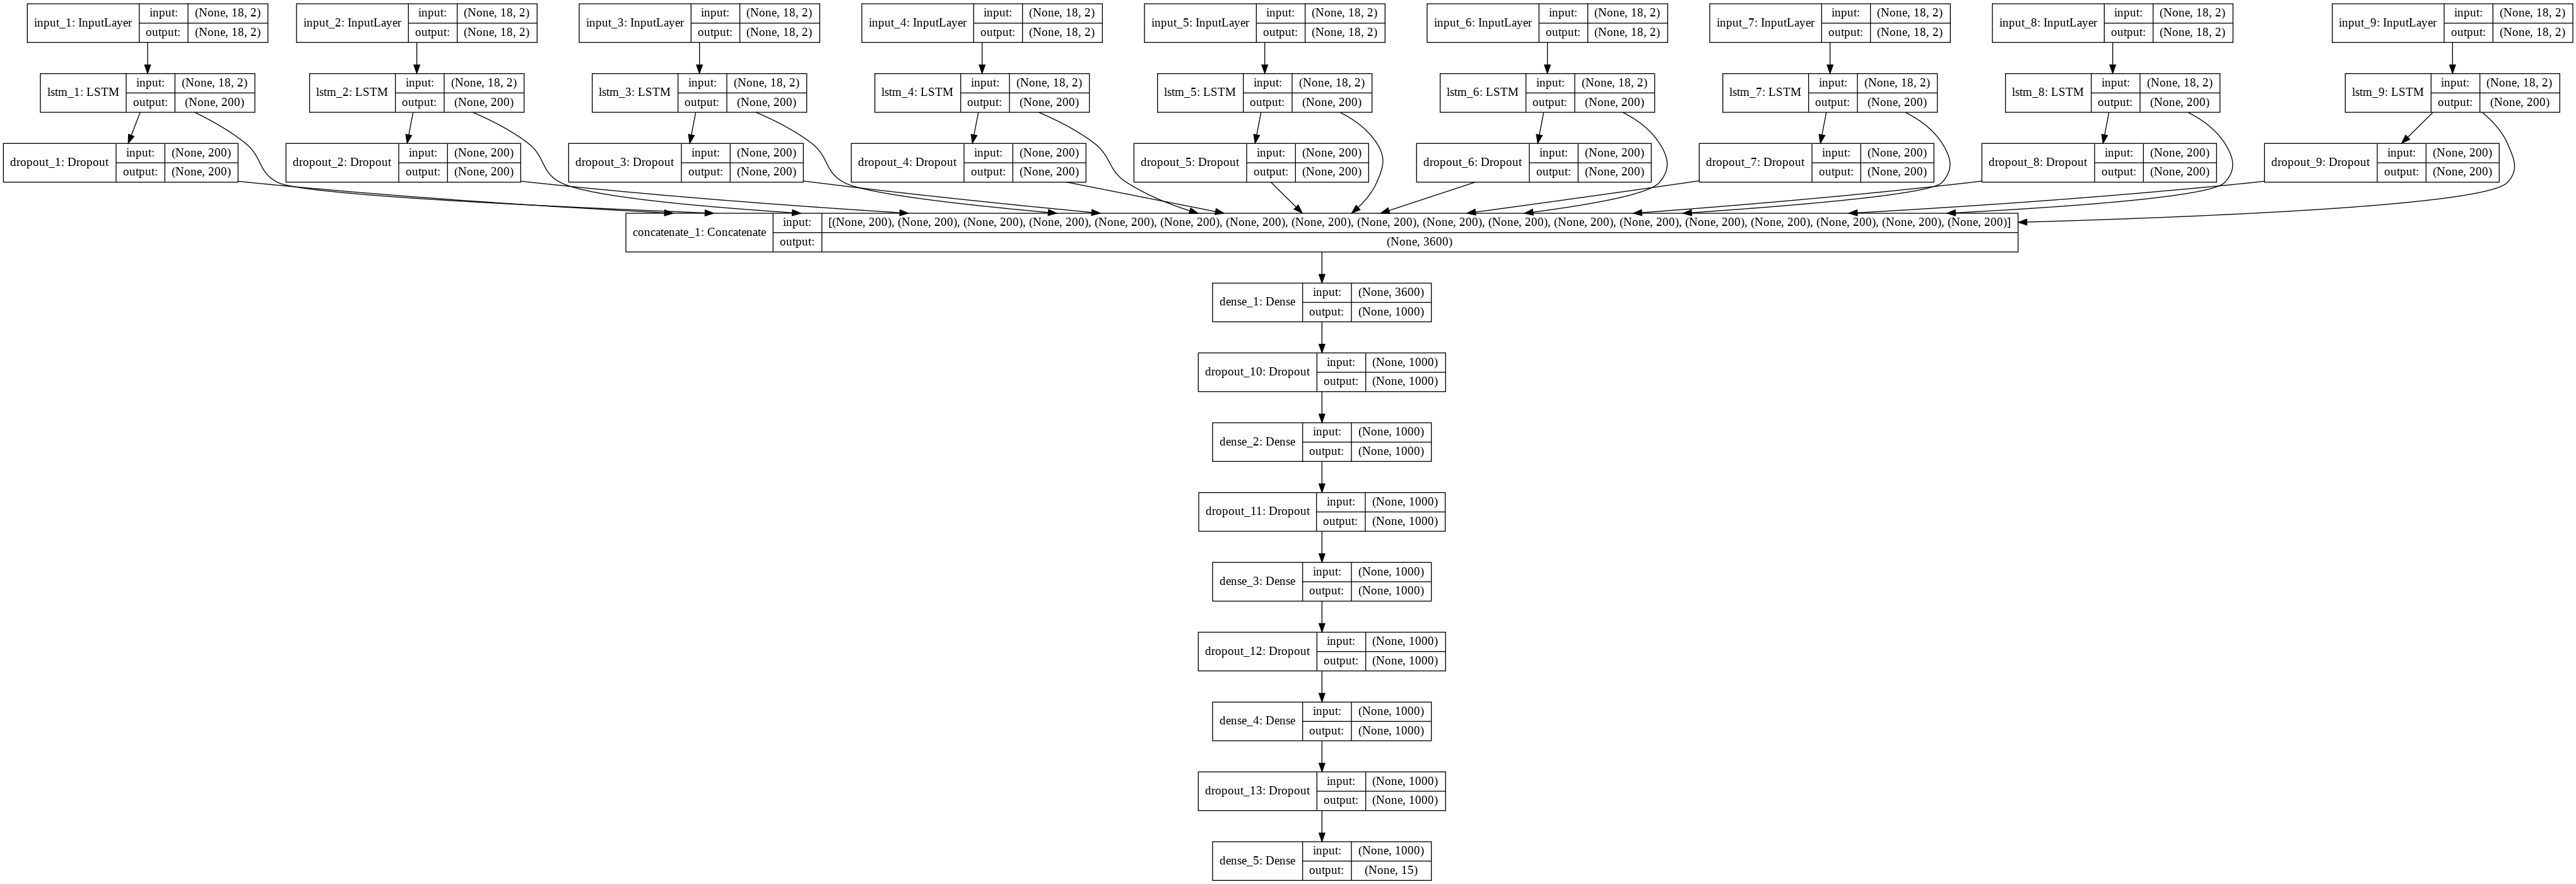

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# ***Fitting***

In [ ]:
allx.shape, ally.shape


((5400, 9, 18, 2), (5400,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(allx,ally,shuffle=True,test_size=0.2, random_state=2, stratify = ally)

In [ ]:
clb = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min', baseline=None, restore_best_weights=True)
from keras.utils import to_categorical
history = model.fit([Xtrain[:,0,:,:],
          Xtrain[:,1,:,:],
          Xtrain[:,2,:,:],
          Xtrain[:,3,:,:],
          Xtrain[:,4,:,:],
          Xtrain[:,5,:,:],
          Xtrain[:,6,:,:],
          Xtrain[:,7,:,:],
          Xtrain[:,8,:,:]],
          to_categorical(ytrain),
          epochs=50,
          validation_data = ([Xtest[:,0,:,:],
                             Xtest[:,1,:,:],
                             Xtest[:,2,:,:],
                             Xtest[:,3,:,:],
                             Xtest[:,4,:,:],
                             Xtest[:,5,:,:],
                             Xtest[:,6,:,:],
                             Xtest[:,7,:,:],
                             Xtest[:,8,:,:]], to_categorical(ytest)),
          batch_size=10,
          callbacks=[clb],
          shuffle=True)



Train on 4320 samples, validate on 1080 samples
Epoch 1/50
4320/4320 [==============================] - 84s 19ms/step - loss: 2.5704 - acc: 0.1287 - val_loss: 2.4524 - val_acc: 0.1769
Epoch 2/50
4320/4320 [==============================] - 79s 18ms/step - loss: 2.4416 - acc: 0.1648 - val_loss: 2.4301 - val_acc: 0.1843
Epoch 3/50
4320/4320 [==============================] - 79s 18ms/step - loss: 2.3543 - acc: 0.2007 - val_loss: 2.2997 - val_acc: 0.1861
Epoch 4/50
4320/4320 [==============================] - 78s 18ms/step - loss: 2.2385 - acc: 0.2394 - val_loss: 2.1974 - val_acc: 0.2204
Epoch 5/50
4320/4320 [==============================] - 79s 18ms/step - loss: 2.1832 - acc: 0.2655 - val_loss: 2.1346 - val_acc: 0.2676
Epoch 6/50
4320/4320 [==============================] - 78s 18ms/step - loss: 2.1301 - acc: 0.2775 - val_loss: 2.0839 - val_acc: 0.2898
Epoch 7/50
4320/4320 [==============================] - 79s 18ms/step - loss: 2.0104 - acc: 0.3120 - val_loss: 1.8746 - val_acc: 0.3620


1080/1080 [==============================] - 1s 1ms/step

train loss = 0.8529403218516597
train accuracy = 0.6078703999519348

test loss = 0.8963705610345911
test accuracy = 0.5962963104248047


Text(0.5, 1.0, 'Test Confusion Matrix')

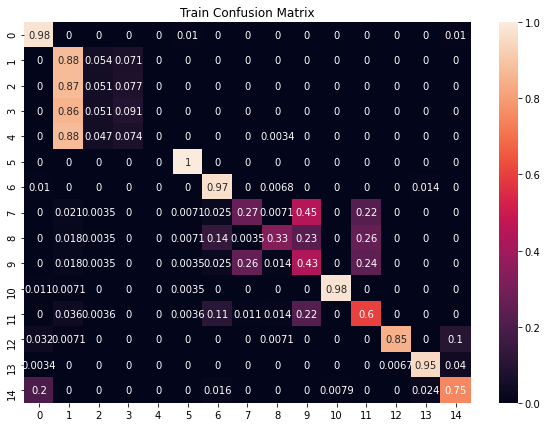

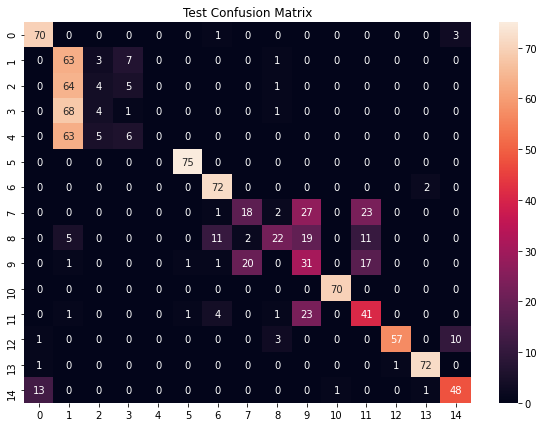

In [ ]:
train_loss, train_accuracy = model.evaluate([Xtrain[:,0,:,:],
                                             Xtrain[:,1,:,:],
                                             Xtrain[:,2,:,:],
                                             Xtrain[:,3,:,:],
                                             Xtrain[:,4,:,:],
                                             Xtrain[:,5,:,:],
                                             Xtrain[:,6,:,:],
                                             Xtrain[:,7,:,:],
                                             Xtrain[:,8,:,:]],
                                            to_categorical(ytrain))

test_loss, test_accuracy = model.evaluate([Xtest[:,0,:,:],
                                           Xtest[:,1,:,:],
                                           Xtest[:,2,:,:],
                                           Xtest[:,3,:,:],
                                           Xtest[:,4,:,:],
                                           Xtest[:,5,:,:],
                                           Xtest[:,6,:,:],
                                           Xtest[:,7,:,:],
                                           Xtest[:,8,:,:]],
                                          to_categorical(ytest))






train_predict = model.predict([Xtrain[:,0,:,:],
                               Xtrain[:,1,:,:],
                               Xtrain[:,2,:,:],
                               Xtrain[:,3,:,:],
                               Xtrain[:,4,:,:],
                               Xtrain[:,5,:,:],
                               Xtrain[:,6,:,:],
                               Xtrain[:,7,:,:],
                               Xtrain[:,8,:,:]])



test_predict = model.predict([Xtest[:,0,:,:],
                              Xtest[:,1,:,:],
                              Xtest[:,2,:,:],
                              Xtest[:,3,:,:],
                              Xtest[:,4,:,:],
                              Xtest[:,5,:,:],
                              Xtest[:,6,:,:],
                              Xtest[:,7,:,:],
                              Xtest[:,8,:,:]])


print('\ntrain loss = {}\ntrain accuracy = {}\n\ntest loss = {}\ntest accuracy = {}'.format(train_loss, train_accuracy, test_loss, test_accuracy))


cm = confusion_matrix(ytrain, np.argmax(train_predict,1),normalize='true')

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True).set_title('Train Confusion Matrix')

cm = confusion_matrix(ytest, np.argmax(test_predict,1))

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True).set_title('Test Confusion Matrix')

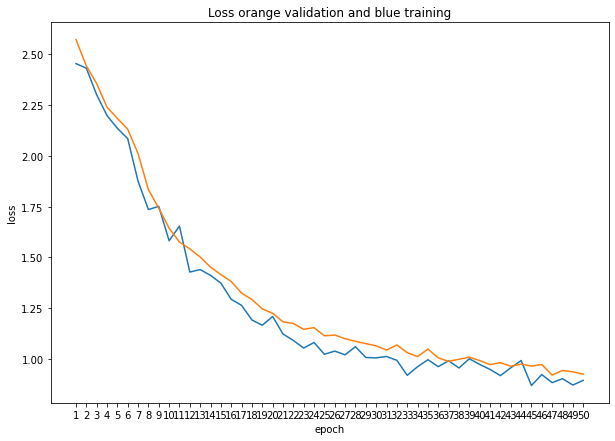

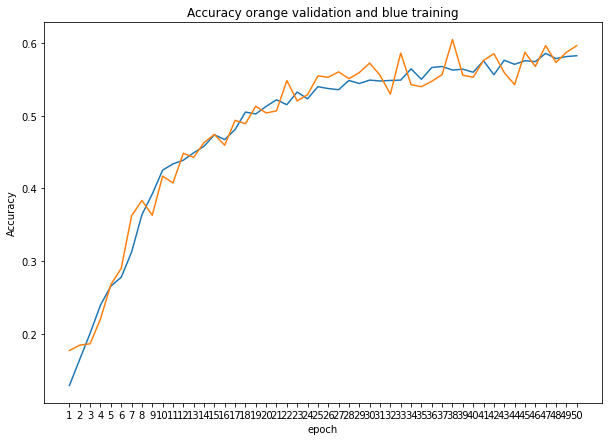

In [ ]:
plt.figure(figsize = (10,7))
epoches_curve = np.arange(1, len(history.history['val_loss'])+1)
plt.xticks(epoches_curve)
plt.plot(epoches_curve, history.history['val_loss'])
plt.plot(epoches_curve, history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss orange validation and blue training')
plt.show()

plt.figure(figsize = (10,7))
plt.plot(epoches_curve, history.history['acc'])
plt.plot(epoches_curve, history.history['val_acc'])
plt.xticks(epoches_curve)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy orange validation and blue training')
plt.show()

## ***TEST***

In [ ]:
Xt=[]
yt=[]
dir_i = 'drive/movements1/test/' #The address of directory for test Movemnts
import glob

n_samples = 1 #Total number of Movments sequence
for i in range(n_samples):

  pics = glob.glob(dir_i+ 'move'+str(i+1)+'/*.png')
  print('i = {}'.format(i))
  img1 = cv2.imread(pics[0])
  img1 = cv2.resize(img1,(300,200))
  old_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

  s1 = np.zeros((67,100,9))

  s1[:,:,0]    = old_gray[:67,:100]
  s1[:,:,1]    = old_gray[:67,100:200]
  s1[:,:,2]    = old_gray[:67,200:]
  s1[:,:,3]    = old_gray[67:2*67,:100]
  s1[:,:,4]    = old_gray[67:2*67,100:200]
  s1[:,:,5]    = old_gray[67:2*67,200:]
  s1[:66,:,6]  = old_gray[2*67:,:100]
  s1[:66,:,7]  = old_gray[2*67:,100:200]
  s1[:66,:,8]  = old_gray[2*67:,200:]
  s1 = s1.astype(np.uint8).copy()
  p0=[]
  for j in range(9):
    if type(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)) == type(None):
      p0.append(np.array([[[33,50]]]).astype(np.float32))
    else:
      p0.append(cv2.goodFeaturesToTrack(s1[:,:,j], mask = None, **feature_params)[0].reshape((1,1,2)))

  for k in range(9):
    Xt.append(p0[k])

  for j in range(1,n_frames):
    img2 = cv2.imread(pics[j+1])
    img2 = cv2.resize(img2,(300,200))
    frame_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    s2 = np.zeros((67,100,9))

    s2[:,:,0]    = frame_gray[:67,:100]
    s2[:,:,1]    = frame_gray[:67,100:200]
    s2[:,:,2]    = frame_gray[:67,200:]
    s2[:,:,3]    = frame_gray[67:2*67,:100]
    s2[:,:,4]    = frame_gray[67:2*67,100:200]
    s2[:,:,5]    = frame_gray[67:2*67,200:]
    s2[:66,:,6]  = frame_gray[2*67:,:100]
    s2[:66,:,7]  = frame_gray[2*67:,100:200]
    s2[:66,:,8]  = frame_gray[2*67:,200:]

    s2 = s2.astype(np.uint8).copy()
    for k in range(9):
      p1, st, err = cv2.calcOpticalFlowPyrLK(s1[:,:,k], s2[:,:,k], p0[k], None, **lk_params)
      Xt.append(p1)

xxt = np.zeros((n_samples,9,n_frames,2))
for iii in range(n_samples):
  for ii in range(9):
    for j in range(n_frames):
      xxt[iii,ii,j,:] = Xt[ iii+(9*j + ii)]

In [ ]:
#shape = xxt.shape
#xxt = xxt.reshape((xxt.shape[0] * xxt.shape[1]* xxt.shape[2],1))
#xxt = scaler.transform(xxt)
#xxt = xxt.reshape(shape)

test_new_predict = model.predict([xxt[:,0,:,:],
                                  xxt[:,1,:,:],
                                  xxt[:,2,:,:],
                                  xxt[:,3,:,:],
                                  xxt[:,4,:,:],
                                  xxt[:,5,:,:],
                                  xxt[:,6,:,:],
                                  xxt[:,7,:,:],
                                  xxt[:,8,:,:]])
test_new_predict = np.argmax(test_new_predict,1)
test_new_predict